In [19]:
import pandas as pd # type: ignore

data = pd.read_csv('CarPrice_Assignment.csv')
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [20]:
data.drop(['car_ID'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [21]:
data.duplicated().sum()

0

# Select most important features that effect on target

## Correlation Analysis
We will calculate and visualize the correlation matrix for the numeric features to see how they correlate with the target variable (Survived).

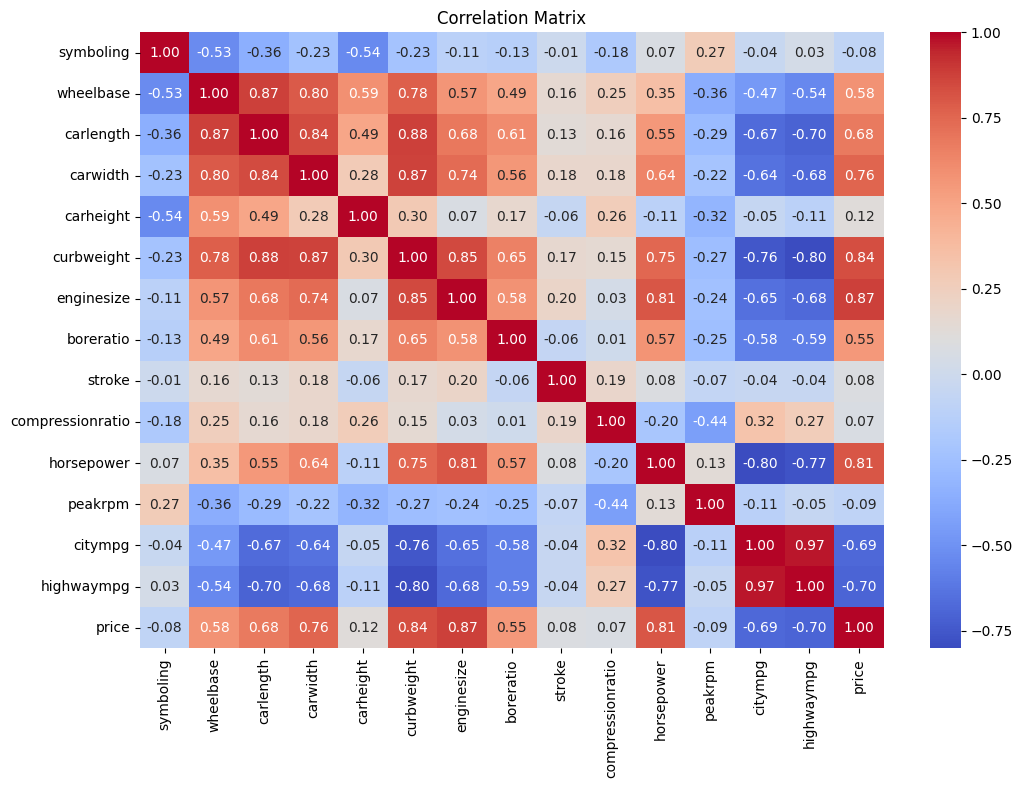

In [22]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

# Select numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# save the 15 most correlated features with price
top_features_correlation = correlation_matrix['price'].abs().sort_values(ascending=False)[:15]


## Feature Importance with Random Forest
We'll train a Random Forest model and extract feature importances.

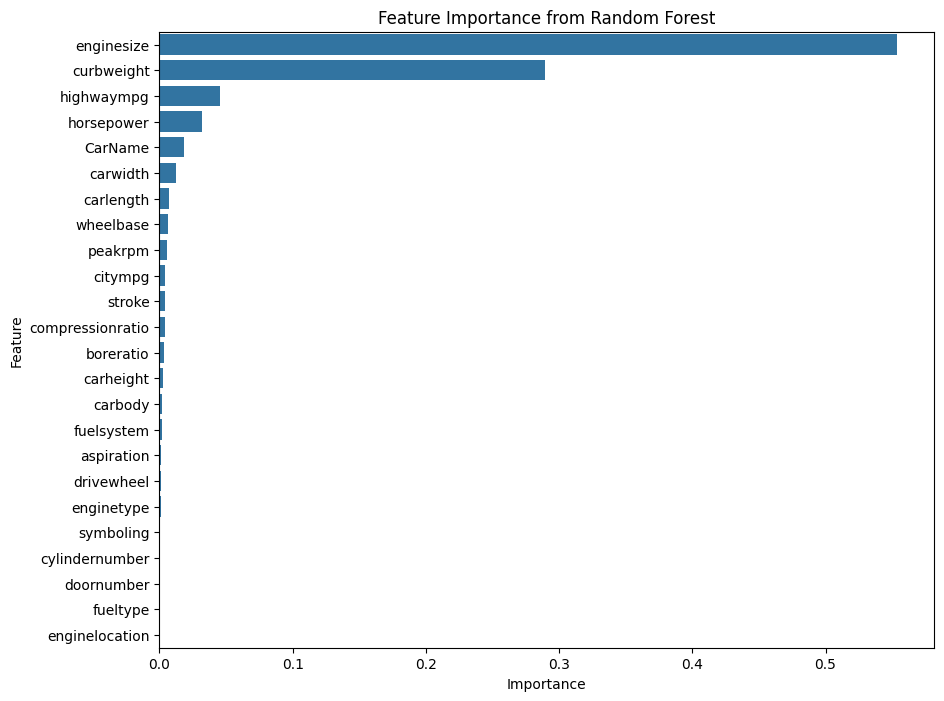

In [23]:
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Preprocessing categorical features
data_encoded = data.copy()
for col in data.select_dtypes(include=['object']).columns:
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

# Separate features and target
X = data_encoded.drop('price', axis=1)
y = data_encoded['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

# save the 15 most important features
top_features_rf = feature_importance_df['Feature'][:15].values


## SHAP Values
SHAP (SHapley Additive exPlanations) values help explain the impact of each feature on the model’s output.

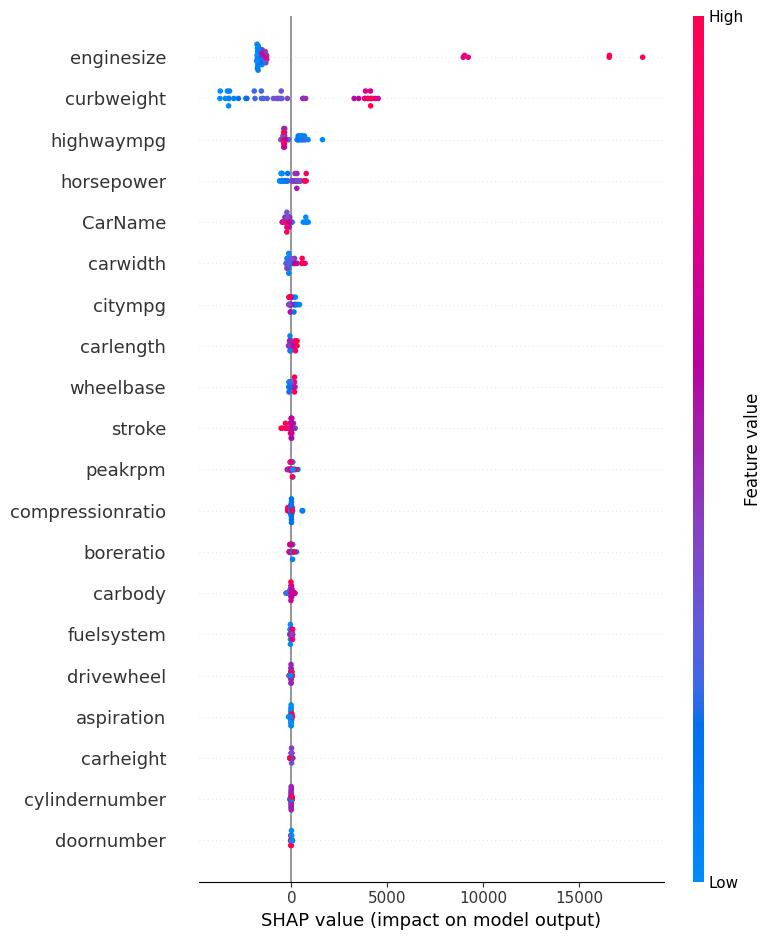

In [24]:
import shap # type: ignore
import numpy as np # type: ignore

# Train a model with SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# Calculate the mean absolute SHAP value for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 15 features
top_feature_indices = np.argsort(mean_shap_values)[-15:]

# Get the names of the top 15 features
top_features_shap = features[top_feature_indices]


## Permutation Importance
We'll calculate permutation importance using a trained model.

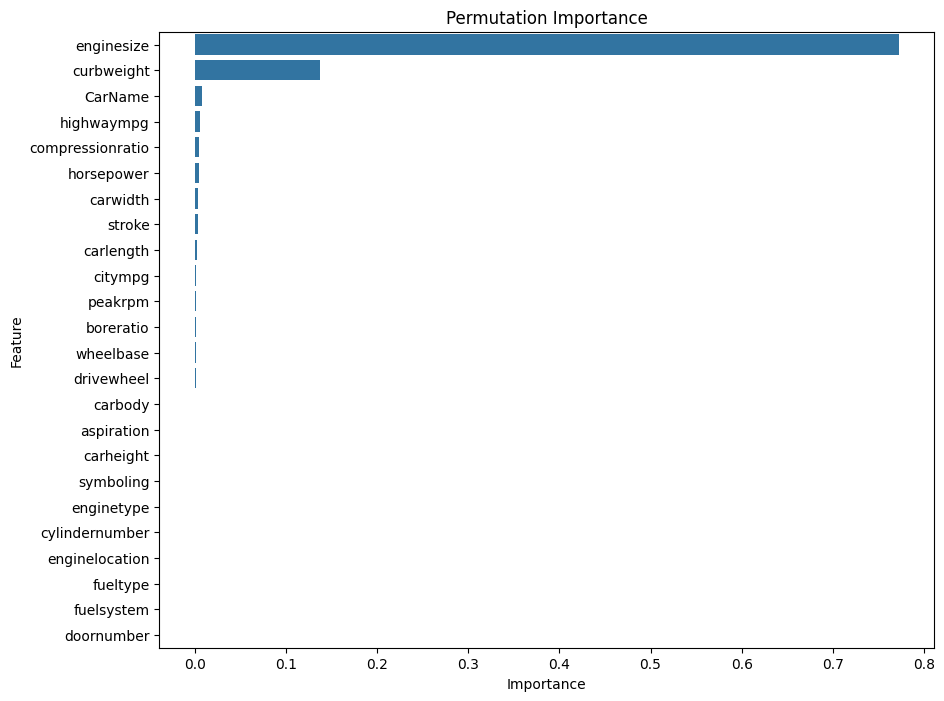

In [25]:
from sklearn.inspection import permutation_importance # type: ignore

# Permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Display permutation importance
perm_importance_df = pd.DataFrame({'Feature': features, 'Importance': perm_importance.importances_mean}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Permutation Importance')
plt.show()

# save the 15 most important features
top_features_perm = perm_importance_df['Feature'][:15].values

## Recursive Feature Elimination (RFE)
We'll use RFE with a Random Forest model to select the most important features.

Top features selected by RFE:
       Feature  Ranking
23  highwaympg        1
1      CarName        1
21     peakrpm        1
20  horsepower        1
15  enginesize        1
8    wheelbase        1
9    carlength        1
10    carwidth        1
22     citympg        1
12  curbweight        1


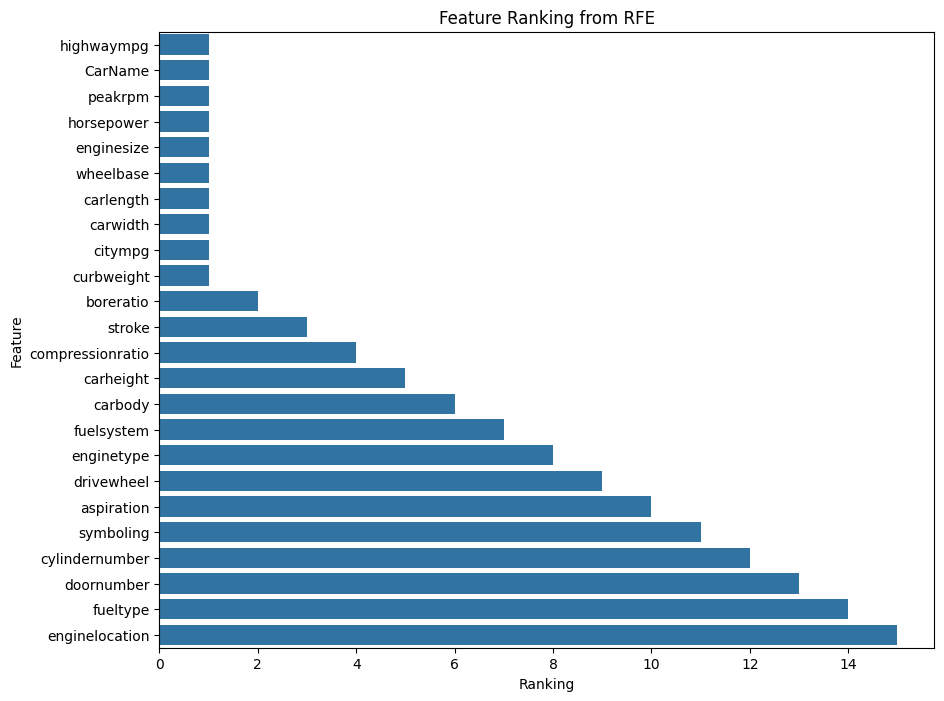

In [26]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize RFE with the Random Forest model and the desired number of features to select
# Here, we choose to select 10 features; you can adjust this number based on your needs
rfe = RFE(estimator=rf, n_features_to_select=10)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_
features = X.columns

# Create a DataFrame to show feature rankings
rfe_results = pd.DataFrame({'Feature': features, 'Ranking': ranking}).sort_values(by='Ranking')

# Display the top features selected by RFE
print("Top features selected by RFE:")
print(rfe_results[rfe_results['Ranking'] == 1])

# Plot feature rankings
plt.figure(figsize=(10, 8))
sns.barplot(x='Ranking', y='Feature', data=rfe_results)
plt.title('Feature Ranking from RFE')
plt.show()

# save the 15 most important features
top_features_rfe = rfe_results[rfe_results['Ranking'] == 1]['Feature'].values

## Select the most Important features

In [27]:
Important_features = list(set(top_features_correlation.index) & set(top_features_rf) & set(top_features_perm) & set(top_features_rfe) & set(top_features_shap))

data_selected = data_encoded[Important_features + ['price']]
data_selected.head()

,wheelbase,peakrpm,curbweight,carlength,horsepower,carwidth,highwaympg,enginesize,citympg,price
0,88.6,5000,2548,168.8,111,64.1,27,130,21,13495.0
1,88.6,5000,2548,168.8,111,64.1,27,130,21,16500.0
2,94.5,5000,2823,171.2,154,65.5,26,152,19,16500.0
3,99.8,5500,2337,176.6,102,66.2,30,109,24,13950.0
4,99.4,5500,2824,176.6,115,66.4,22,136,18,17450.0


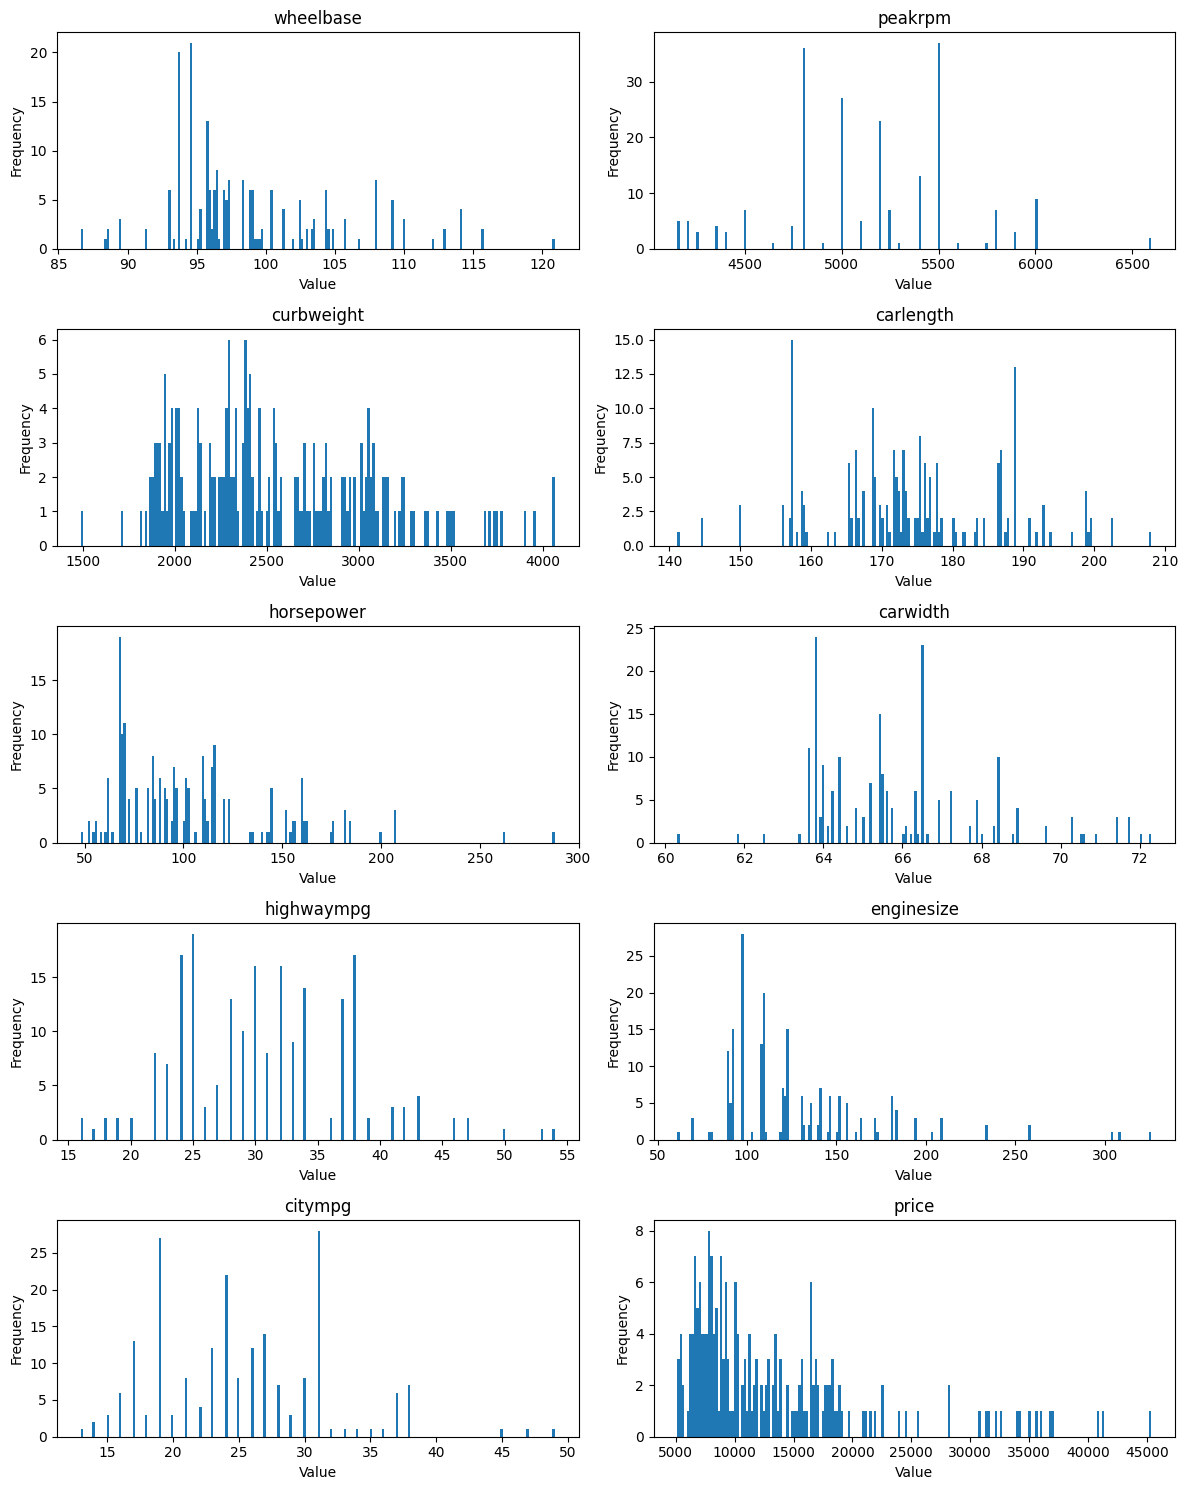

In [28]:
import matplotlib.pyplot as plt # type: ignore

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column and plot histogram
for i, column in enumerate(data_selected.select_dtypes(include=['int64', 'float64']).columns):

    # Select the current axis
    ax = axes[i]
    
    # Plot histogram
    data_selected[column].plot.hist(ax=ax, bins=200)
    
    # Set title and labels
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

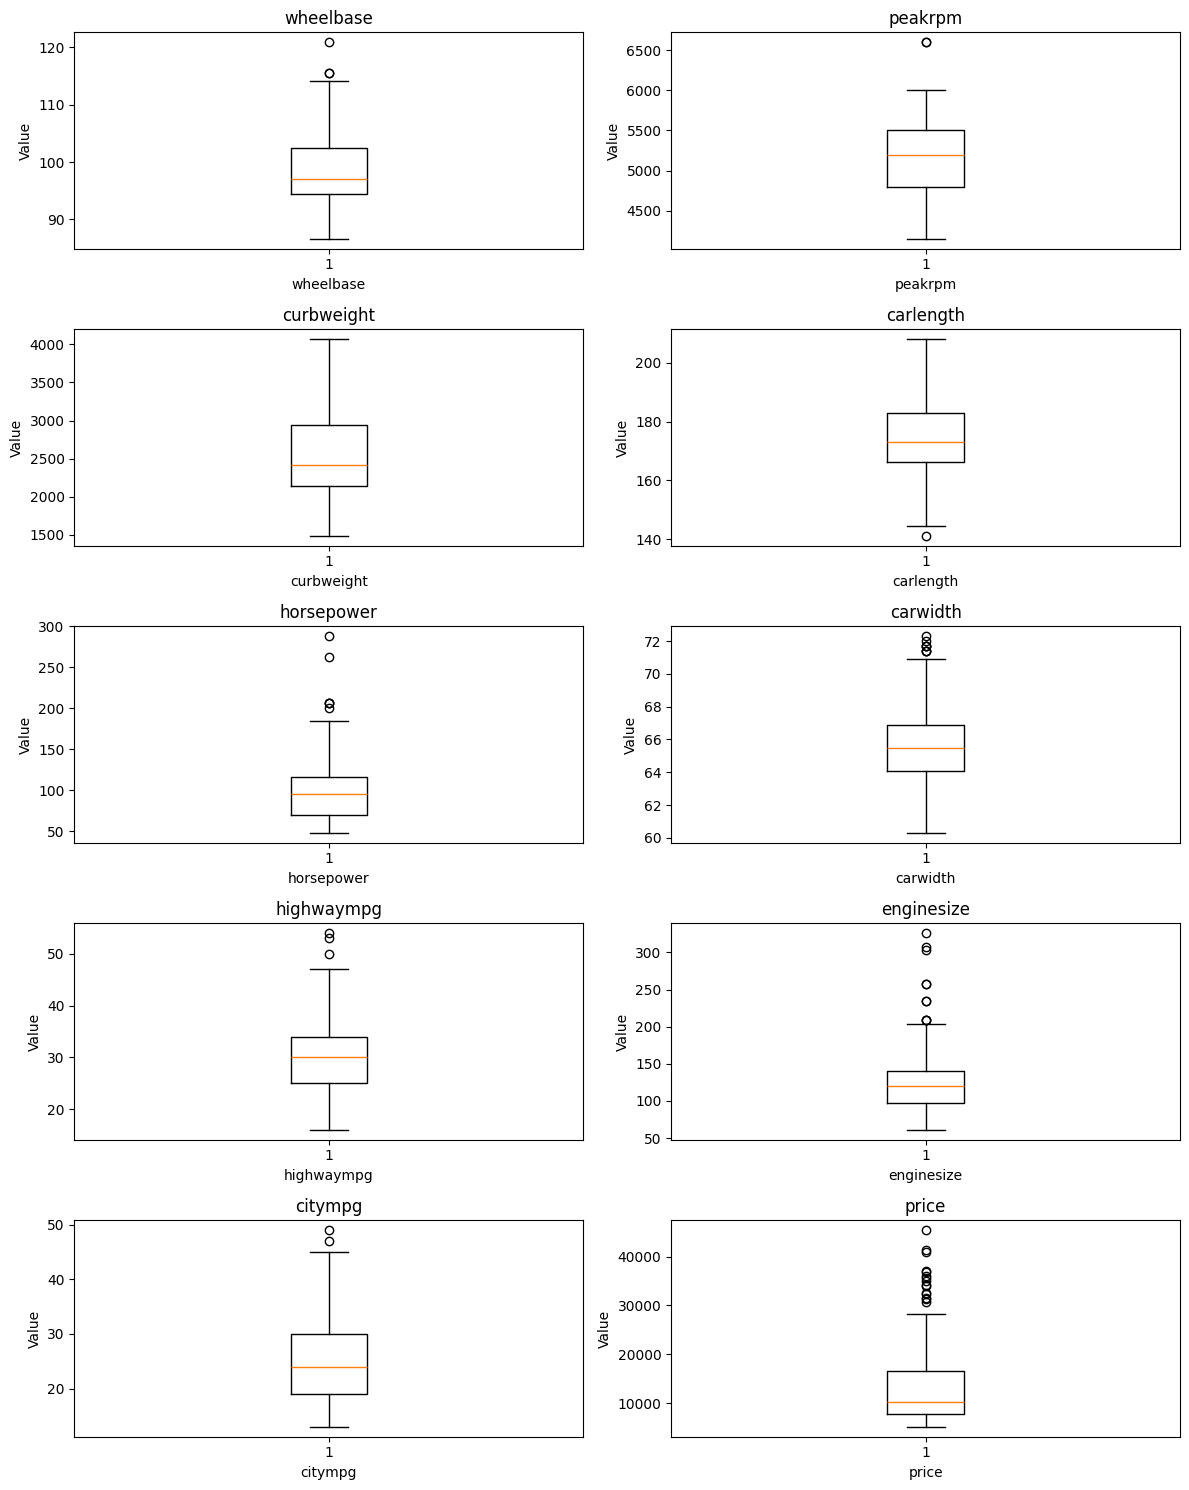

In [29]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column and plot boxplot
for i, column in enumerate(data_selected.select_dtypes(include=['int64', 'float64']).columns):
    # Select the current axis
    ax = axes[i]
    
    # Plot boxplot
    ax.boxplot(data_selected[column])
    
    # Set title and labels
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Value')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Modelling

## Preprocessing
Remove outliers and scale the features

In [30]:
# Calculate the IQR for the "enginesize" column
Q1 = data_selected["enginesize"].quantile(0.25)
Q3 = data_selected["enginesize"].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the "enginesize" column
data_selected = data_selected[(data_selected["enginesize"] >= lower_bound) & (data_selected["enginesize"] <= upper_bound)]

# Scale the data
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

data_scaled = data_selected.copy()

columns = data_scaled.drop('price', axis=1).columns

data_scaled[columns] = scaler.fit_transform(data_selected[columns])

data_scaled.head()

,wheelbase,peakrpm,curbweight,carlength,horsepower,carwidth,highwaympg,enginesize,citympg,price
0,-1.765628,-0.282974,0.115226,-0.360919,0.309877,-0.824921,-0.677696,0.332936,-0.758676,13495.0
1,-1.765628,-0.282974,0.115226,-0.360919,0.309877,-0.824921,-0.677696,0.332936,-0.758676,16500.0
2,-0.683969,-0.282974,0.720651,-0.150623,1.524612,-0.098927,-0.832802,1.091457,-1.078550,16500.0
3,0.287690,0.760124,-0.349301,0.322544,0.055630,0.264071,-0.212376,-0.391107,-0.278865,13950.0
4,0.214357,0.760124,0.722852,0.322544,0.422876,0.367784,-1.453227,0.539805,-1.238487,17450.0


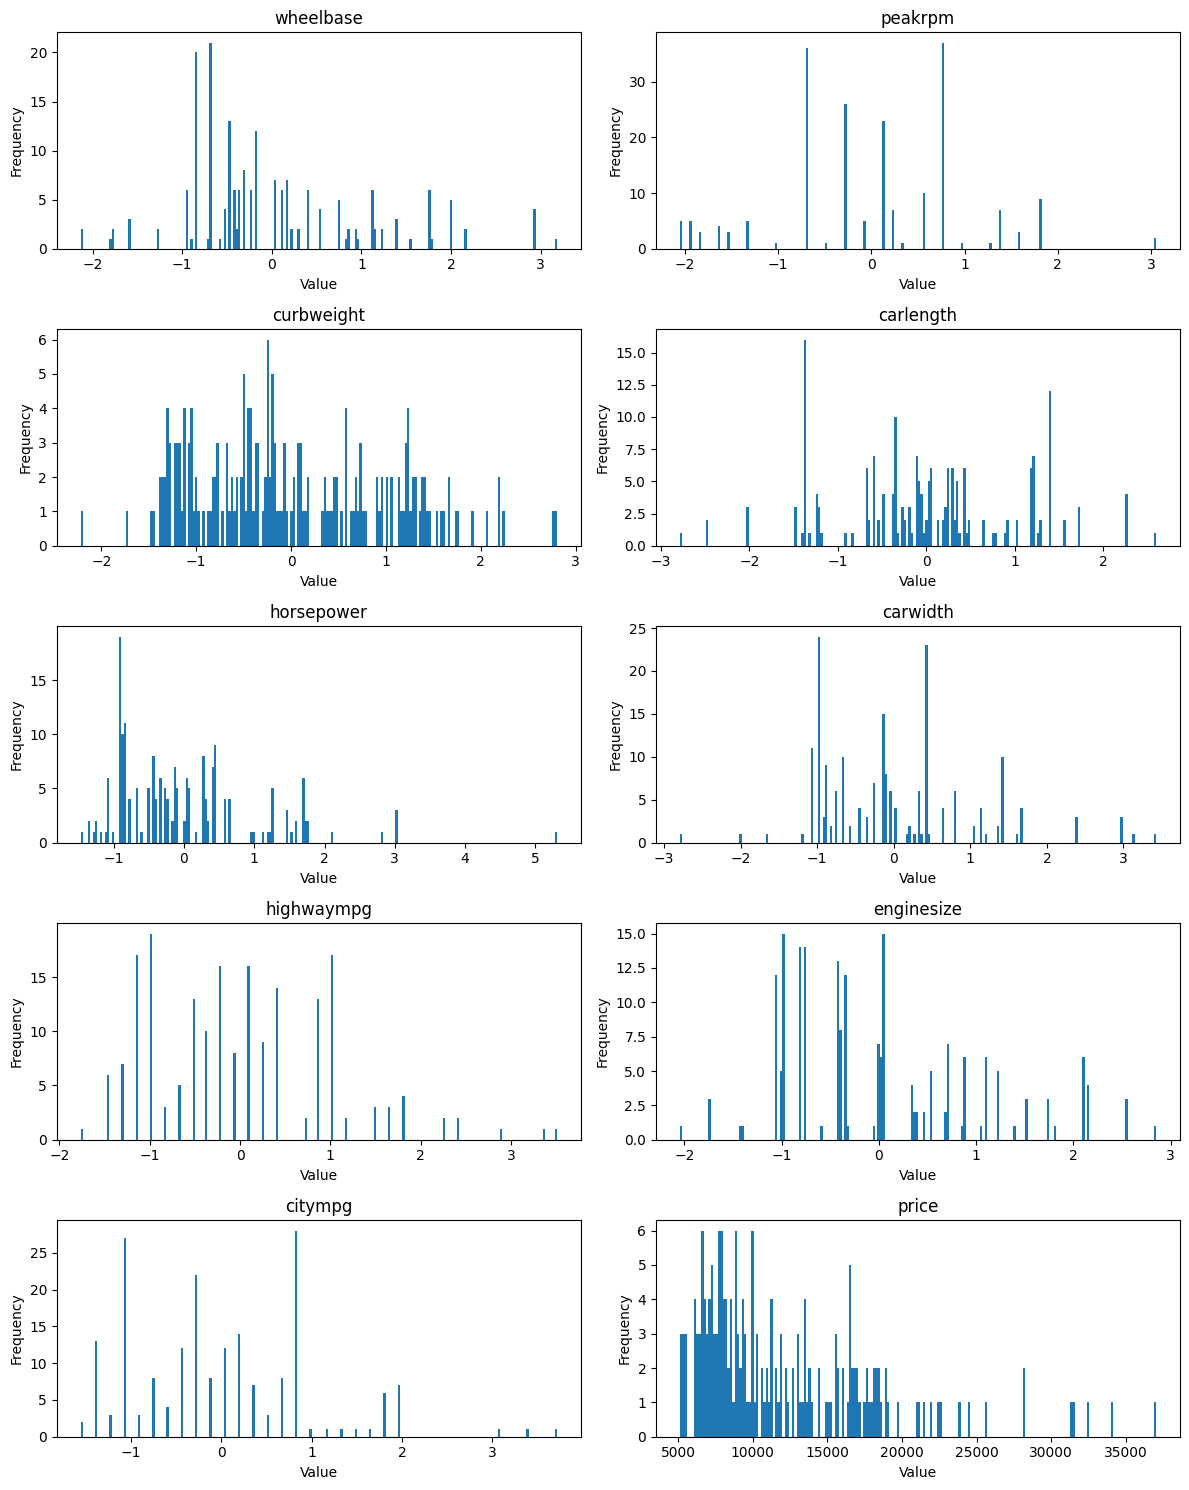

In [31]:
import matplotlib.pyplot as plt # type: ignore

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column and plot histogram
for i, column in enumerate(data_scaled.select_dtypes(include=['int64', 'float64']).columns):

    # Select the current axis
    ax = axes[i]
    
    # Plot histogram
    data_scaled[column].plot.hist(ax=ax, bins=200)
    
    # Set title and labels
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Separation

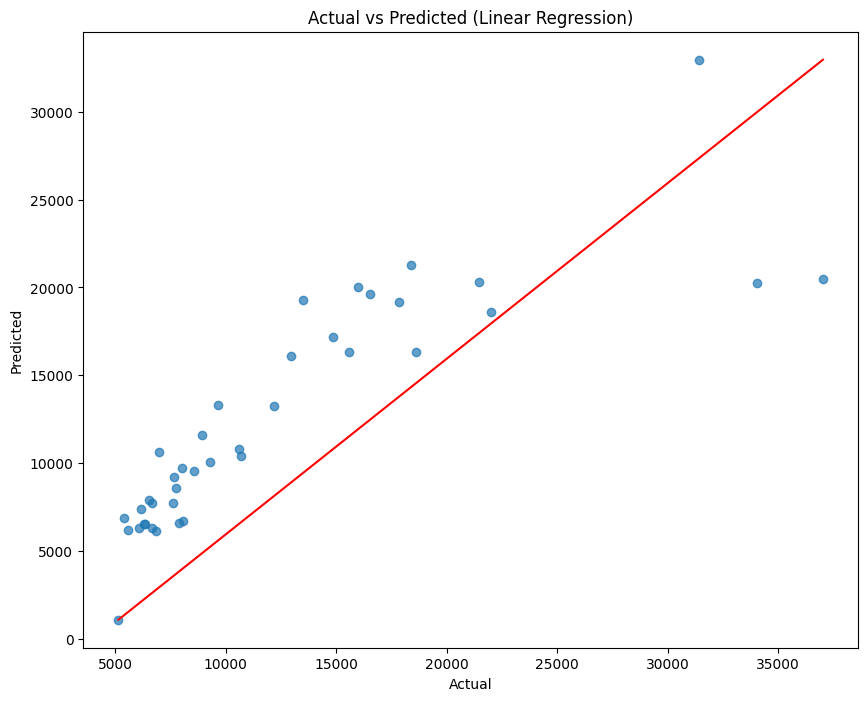

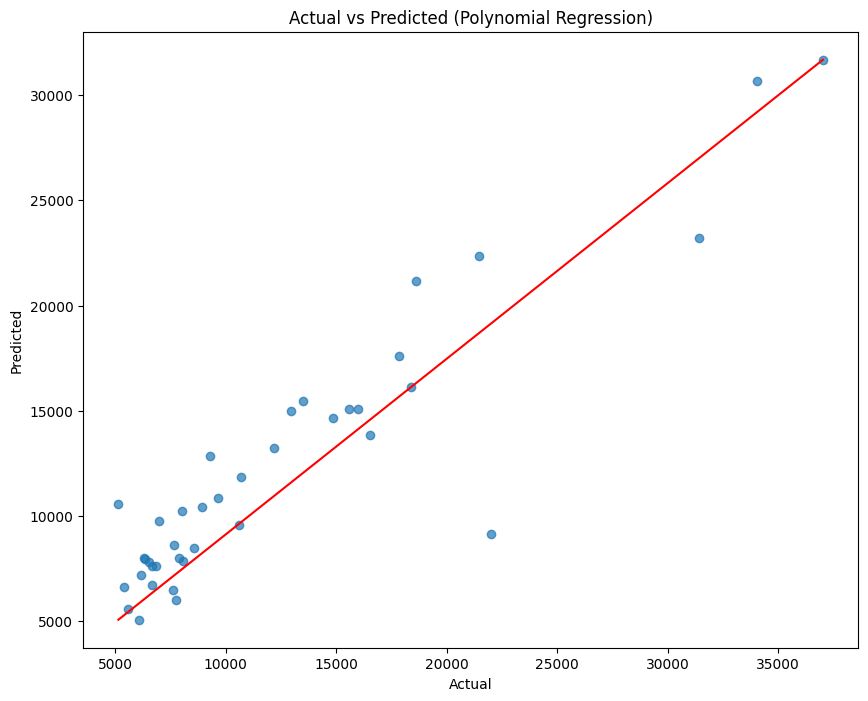

Linear Regression Results:
Mean Squared Error: 16384849.211398998
R-squared: 0.7335392734804018
Cross-Validation R-squared: 0.6124597357193644

Polynomial Regression Results:
Polynomial Regression Mean Squared Error: 9736527.131484333
Polynomial Regression R-squared: 0.8416584699828571
Polynomial Regression Cross-Validation R-squared: -0.7522238113145485


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# Separate features and target
X = data_scaled.drop('price', axis=1)
y = data_scaled['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)


# Plot the predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red')  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions using the polynomial model
y_pred_poly = poly_model.predict(X_test_poly)

# Calculate the mean squared error for polynomial regression
mse_poly = mean_squared_error(y_test, y_pred_poly)


# Calculate the R-squared value for polynomial regression
r2_poly = r2_score(y_test, y_pred_poly)


# Plot the predicted vs actual values for polynomial regression
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_poly, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_pred_poly), max(y_pred_poly)], color='red')  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Polynomial Regression)')
plt.show()

# Optional: Cross-validation to test model stability
cv_scores_linear = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_scores_poly = cross_val_score(poly_model, poly_features.fit_transform(X), y, cv=5, scoring='r2')

# Display the results
print('Linear Regression Results:')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Cross-Validation R-squared: {cv_scores_linear.mean()}')
print('\nPolynomial Regression Results:')
print(f'Polynomial Regression Mean Squared Error: {mse_poly}')
print(f'Polynomial Regression R-squared: {r2_poly}')
print(f'Polynomial Regression Cross-Validation R-squared: {cv_scores_poly.mean()}')
